<a href="https://colab.research.google.com/github/syslogg/cervix-predict/blob/master/MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Created on Aug

@author: Hendy Rodrigues F.Silva
"""

import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import os

#Data Augument
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from imutils import paths
import cv2

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import classification_report

#Cross Validator
from sklearn.model_selection import KFold

from keras.models import Sequential
#import SpatialPyramidPooling

# Layers
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPool2D, Activation

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
BATCH_SIZE_HERLEV = 917

DIRECTORY_HERLEV = r'drive/My Drive/Colab Notebooks/tcc/dataset/herlev'

LABELS_HERLEV = set([
        'carcinoma_in_situ',
        'light_dysplastic',
        'moderate_dysplastic', # drive/'My Drive'/'Colab Notebooks'/tcc/
        'normal_columnar',
        'normal_intermediate',
        'normal_superficiel',
        'severe_dysplastic'])

In [0]:
def load_images(path, labelsPath=[], target_resizer=(250, 250)):
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []

    for imgPath in imagePaths:
        label = imgPath.split(os.path.sep)[-2]

        if label not in labelsPath:
            continue

        image = cv2.imread(imgPath)
        image = cv2.resize(image,target_resizer)

        data.append(image)
        labels.append(label)

    return np.array(data), labels

In [0]:

X, Y_without_encoded = load_images(DIRECTORY_HERLEV, LABELS_HERLEV)
X = X / 255


In [0]:
# Codificação One Hot
lb = LabelBinarizer()
Y = lb.fit_transform(Y_without_encoded)

In [0]:
# Divisão de DataSets de Treino e Teste
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=1)

In [0]:
# -=== Trabalhar com Data Augmentation ===-
dataGenerator = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
                        	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
                        	horizontal_flip=True, fill_mode="nearest")

In [9]:
# 2. Montagem da Rede Neural Convolucional

class NeuralNetwork:
    @staticmethod
    def build(num_filter, num_class):
        cnn = Sequential()

        # Passo 1: Criar Camada Convolucional
        cnn.add(Conv2D(num_filter, kernel_size=(7, 7), activation='relu',input_shape=(250, 250, 3)))

        # Passo 2: Efetuar o MaxPooling
        cnn.add(MaxPool2D())
        
        num_filter = num_filter * 2
        cnn.add(Conv2D(num_filter, kernel_size=(5, 5), activation='relu'))
        cnn.add(MaxPool2D())
        
        num_filter = num_filter * 2
        cnn.add(Conv2D(num_filter, kernel_size=(3, 3), activation='relu'))
        cnn.add(MaxPool2D())
        
        cnn.add(Conv2D(num_filter, kernel_size=(3, 3), activation='relu'))
        cnn.add(Conv2D(num_filter, kernel_size=(3, 3), activation='relu'))
        cnn.add(Conv2D(num_filter, kernel_size=(3, 3), activation='relu'))
        cnn.add(MaxPool2D())
        
        # Passo 3: Flatten as saidas da camada convolucional
        cnn.add(Flatten())

        # Passo 4: Exibir saida com uma camada totalmente conectada (Fully-Connected)
        cnn.add(Dense(num_class))
        cnn.add(Activation('softmax'))
        #cnn.add(SpatialPyramidPooling([1, 2, 4])) # Pesquisar sobre
        
        #https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/

        return cnn

model = NeuralNetwork.build(8,len(lb.classes_))
model.compile(
            loss='categorical_crossentropy', # Verificar cada parametro.
            optimizer='adam',
            metrics=['accuracy']
)

W0902 23:37:16.073819 139726810085248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 23:37:16.092803 139726810085248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 23:37:16.096306 139726810085248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 23:37:16.114850 139726810085248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0902 23:37:16.197931 139726810085248 deprecation_wrapp

In [10]:
# 3. Treinamento da Rede Neural

STEPS_PER_EPOCH = len(X_train)
EPOCHS = 30
BATCH_SIZE=32

result = model.fit_generator(dataGenerator.flow(X_train,Y_train, batch_size=BATCH_SIZE),
                             validation_data=(X_test, Y_test), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

W0902 23:37:16.677542 139726810085248 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0902 23:37:16.754276 139726810085248 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
687/687 [==============================] - 256s 373ms/step - loss: 1.6876 - acc: 0.3116 - val_loss: 1.4294 - val_acc: 0.3783
Epoch 2/30
687/687 [==============================] - 251s 365ms/step - loss: 1.3431 - acc: 0.4580 - val_loss: 1.3055 - val_acc: 0.4435
Epoch 3/30
687/687 [==============================] - 251s 365ms/step - loss: 1.0966 - acc: 0.5536 - val_loss: 1.1633 - val_acc: 0.5348
Epoch 4/30
687/687 [==============================] - 252s 366ms/step - loss: 0.9810 - acc: 0.5985 - val_loss: 1.1916 - val_acc: 0.5174
Epoch 5/30
687/687 [==============================] - 251s 365ms/step - loss: 0.8860 - acc: 0.6375 - val_loss: 1.2663 - val_acc: 0.5000
Epoch 6/30
687/687 [==============================] - 249s 362ms/step - loss: 0.7924 - acc: 0.6809 - val_loss: 1.1941 - val_acc: 0.5391
Epoch 7/30
687/687 [==============================] - 248s 361ms/step - loss: 0.7344 - acc: 0.7098 - val_loss: 1.4739 - val_acc: 0.5478
Epoch 8/30
687/687 [============================

In [11]:
# 4. Predizer modelo de aprendizado

predictions = model.predict(X_test, batch_size=32)
print(classification_report(Y_test.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

                     precision    recall  f1-score   support

  carcinoma_in_situ       0.67      0.47      0.55        38
   light_dysplastic       0.53      0.74      0.62        46
moderate_dysplastic       0.36      0.32      0.34        37
    normal_columnar       0.48      0.52      0.50        25
normal_intermediate       0.82      0.82      0.82        17
 normal_superficiel       0.84      0.89      0.86        18
  severe_dysplastic       0.47      0.41      0.43        49

           accuracy                           0.55       230
          macro avg       0.60      0.60      0.59       230
       weighted avg       0.55      0.55      0.55       230



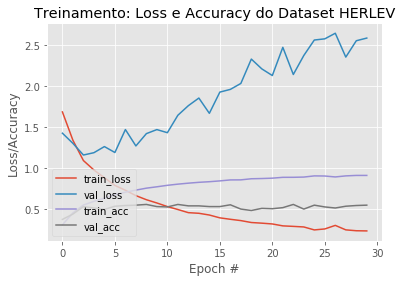

In [12]:
# Grafico com Histórico de acuracia por Epoch

N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), result.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), result.history["val_acc"], label="val_acc")
plt.title("Treinamento: Loss e Accuracy do Dataset HERLEV")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [13]:
#plt.savefig(args["plot"])


# Leitura do banco de imagem

# -=== Estudo sobre o Banco de Imagem Herlev ===-



# - Quantidade de imagens para cada valor:

# 1. Montagem do Dataset


"""
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    shear_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    validation_split=0.2)

valid_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    directory=r'./dataset/herlev',
    target_size=(250, 250),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    seed=1,
    shuffle=True,
    subset='training'
)

validator_generator = valid_datagen.flow_from_directory(
    directory=r'./dataset/herlev',
    target_size=(250, 250),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    seed=1,
    shuffle=True,
    subset='validation'
)
"""





# 3. Treinamento Rede Neural

"""
model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=10,
        validation_data=validator_generator,
        validation_steps=len(validator_generator)
)
"""

# 4. Prever Dados

# model.predict()

# 5. Postar Resultados

'\nmodel.fit_generator(\n        train_generator,\n        steps_per_epoch=len(train_generator),\n        epochs=10,\n        validation_data=validator_generator,\n        validation_steps=len(validator_generator)\n)\n'